# GEONE - Accept-reject sampler

Rejection algorithm for generating samples according to a given uni- or multi-variate density function.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


## Accept-reject sampler
The function `geone.randProcess.acceptRejectSampler(n, xmin, xmax, f)` generates `n` points (can be multi-variate) in a box-shape domain of lower bound(s) `xmin` and upper bound(s) `xmax`, according to a density proportional to the function `f`, based on the accept-reject algorithm.

Let `g_rvs` a function returning random variates sample(s) from an instrumental distribution with density proportional to `g`, and `c` a constant such that `c*g(x) >= f(x)` for any `x` (in `[xmin, xmax[` (can be multi-dimensional), i.e. `x[i]` in `[xmin[i], xmax[i][` for any i). Let `fd` (resp. `gd`) the density function proportional to `f` (resp. `g`); the alogrithm consists in the following steps to generate samples `x ~ fd`:

- generate `y ~ gd` (using `grvs`)
- generate `u ~ Unif([0,1])`
- if `u < f(y)/c*g(y)`, then accept `x` (reject `x` otherwise)

The value of `c`, and the instrumental distribution (both `g` and `g_rvs`) can be specified as keyword arguments. The default instrumental distribution (if both `g` and `g_rvs` set to `None`) is the uniform distribution (`g=1`). If the domain (`[xmin, xmax[`) is infinite, the instrumental distribution (`g`, and `g_rvs`) and `c` must be specified.

### Example - 1 variable on a finite domain

In [3]:
# Function, proportional to target density
def f(x):
    return np.exp(-x**2/10) * (np.cos(np.pi*x) + 2)

# Domain
xmin, xmax = 1, 5

# Draw samples
n = 500000
np.random.seed(1239)
t1 = time.time()
x, t = gn.randProcess.acceptRejectSampler(n, xmin, xmax, f, return_accept_ratio=True, show_progress=False)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Acceptance ratio = {t:.4g}')

Elapsed time: 0.1 sec
Acceptance ratio = 0.4269


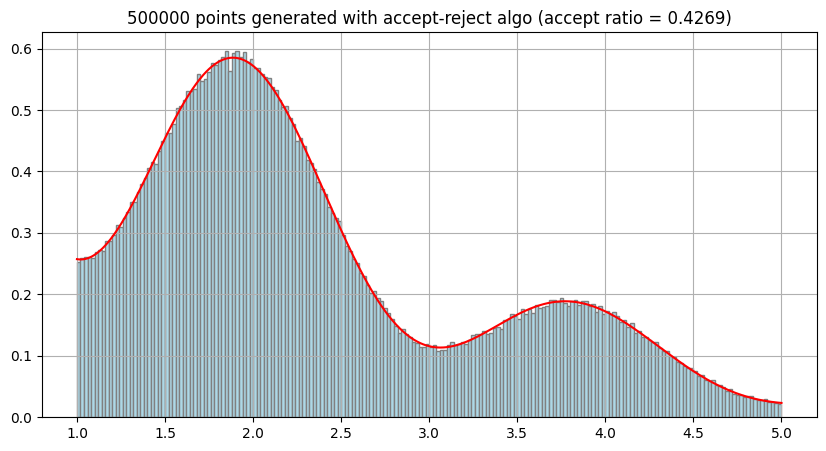

In [4]:
# Target density
fint = scipy.integrate.quad(f, xmin, xmax)[0]
xx = np.linspace(xmin, xmax, 1000)
yy = f(xx)/fint

# Plot
plt.figure(figsize=(10, 5))
plt.hist(x, bins=200, density=True, color='lightblue', edgecolor='gray', label='sample (A-R)')
plt.plot(xx, yy, 'r', label='target density')
plt.grid()
plt.title(f'{n} points generated with accept-reject algo (accept ratio = {t:.4g})')
plt.show()

#### Specifying `c` 
If the uniform distribution is used as the instrumental distribution (`g=1`, default), `c` must be a value greater than or equal to the maximum of `f`.

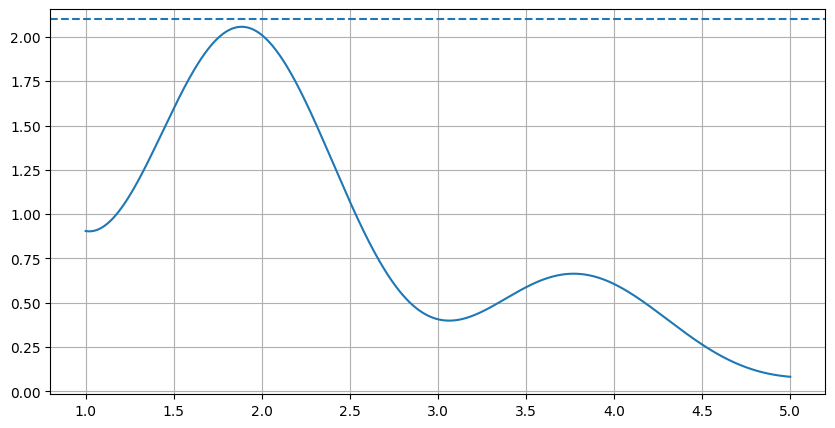

In [5]:
c = 2.1
plt.figure(figsize=(10, 5))
plt.plot(xx, f(xx))
plt.axhline(y=c, ls='dashed')
plt.grid()
plt.show()

Elapsed time: 0.093 sec
Acceptance ratio = 0.4188


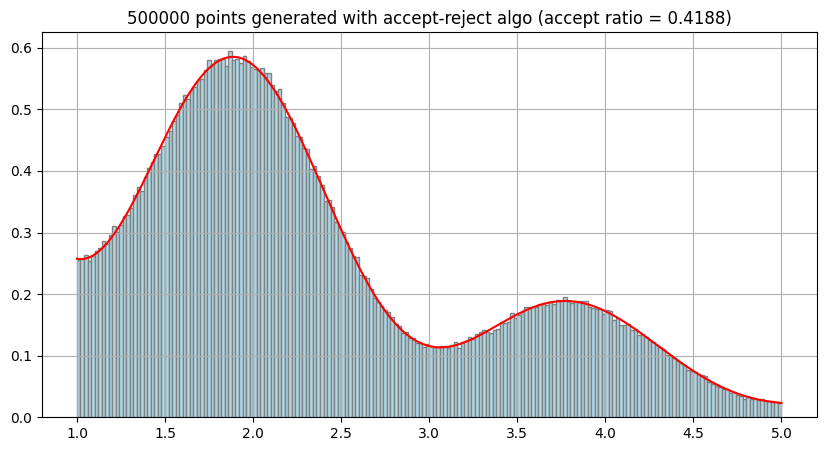

In [6]:
# Draw samples
n = 500000
np.random.seed(1239)
t1 = time.time()
x, t = gn.randProcess.acceptRejectSampler(n, xmin, xmax, f, c=c, return_accept_ratio=True, show_progress=False)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Acceptance ratio = {t:.4g}')

# Plot
plt.figure(figsize=(10, 5))
plt.hist(x, bins=200, density=True, color='lightblue', edgecolor='gray', label='sample (A-R)')
plt.plot(xx, yy, 'r', label='target density')
plt.grid()
plt.title(f'{n} points generated with accept-reject algo (accept ratio = {t:.4g})')
plt.show()

### Example - 1 variable on an infinite domain
With an infinite domain, the instrumental distribution (`g` and `g_rvs`), and `c` (greater than or equal to the maximum of `f/g`) must be specified.

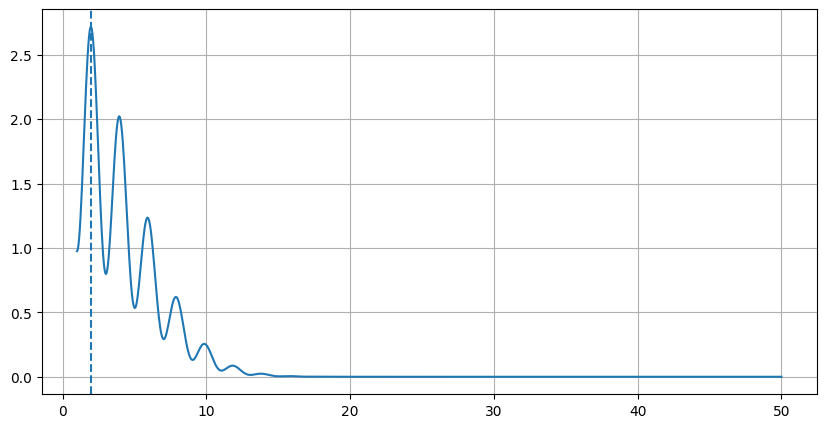

In [7]:
# function f, proopotional to the target distribution
def f(x):
    return np.exp(-x**2/40) * (np.cos(np.pi*x) + 2)

# Domain
xmin, xmax = 1, np.inf

# Search the max of f (on a sub-domain)
xmax_tmp = 50.0
h = lambda x: -f(x)
res = scipy.optimize.differential_evolution(h, bounds=[(xmin, xmax_tmp)])
mu = res.x # maximizing f

# Plot
xx = np.linspace(xmin, xmax_tmp, 1000)
yy = f(xx)

plt.figure(figsize=(10, 5))
plt.plot(xx, yy)
plt.axvline(x=mu, ls='dashed')
plt.grid()
plt.show()

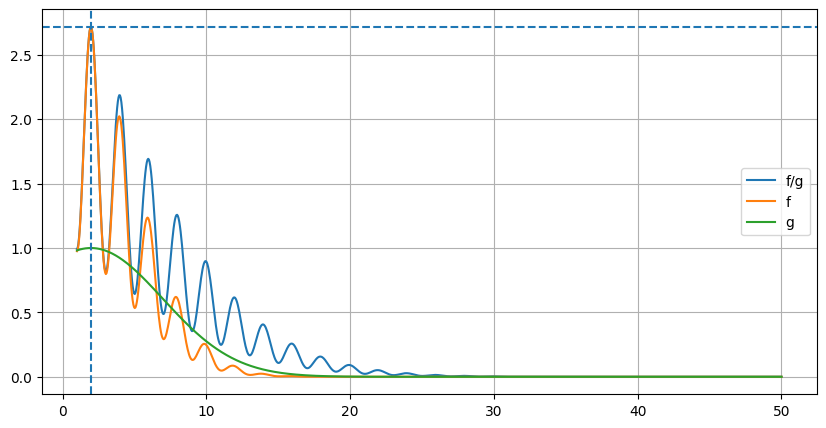

In [8]:
# Set instrumental distribution (g, g_rvs)
s = 5.0
g = lambda x: np.exp(-0.5*((x-mu)/s)**2)
# g = scipy.stats.norm(loc=mu, scale=s).pdf # Also possible
g_rvs = scipy.stats.norm(loc=mu, scale=s).rvs

# Search the max of f(x)/g(x) (on a sub-domain)
h = lambda x: -f(x)/g(x)
res = scipy.optimize.differential_evolution(h, bounds=[(xmin, xmax_tmp)])
c = -res.fun # max f/g

# Plot
xx = np.linspace(xmin, xmax_tmp, 1000)
yy = -h(xx)

plt.figure(figsize=(10, 5))
plt.plot(xx, yy, label= 'f/g')
plt.plot(xx, f(xx), label= 'f')
plt.plot(xx, g(xx), label= 'g')
plt.axvline(x=res.x, ls='dashed')
plt.axhline(y=c, ls='dashed')
plt.grid()
plt.legend()
plt.show()

In [9]:
# Draw samples
n = 500000
np.random.seed(1239)
t1 = time.time()
x, t = gn.randProcess.acceptRejectSampler(n, xmin, xmax, f, c=c, g=g, g_rvs=g_rvs, return_accept_ratio=True, show_progress=False)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Acceptance ratio = {t:.4g}')

Elapsed time: 0.11 sec
Acceptance ratio = 0.2701


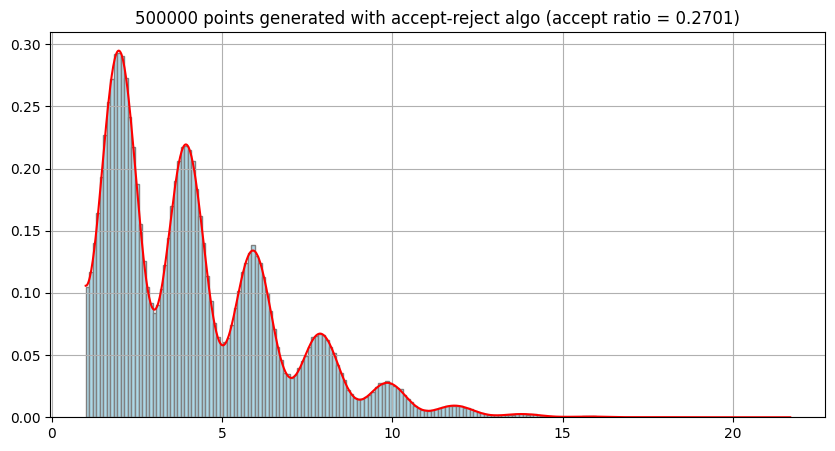

In [10]:
# Target density
fint = scipy.integrate.quad(f, xmin, xmax)[0]
xx = np.linspace(xmin, x.max(), 1000)
yy = f(xx)/fint

# Plot
plt.figure(figsize=(10, 5))
plt.hist(x, bins=200, density=True, color='lightblue', edgecolor='gray', label='sample (A-R)')
plt.plot(xx, yy, 'r', label='target density')
plt.grid()
plt.title(f'{n} points generated with accept-reject algo (accept ratio = {t:.4g})')
plt.show()

### Example - 2 variables on a finite domain

In [11]:
# Function of 2 variables, proportional to target density
def f_2var(x0, x1):
    return np.exp(-((x0-1.0)**2+(x1-1.0)**2)/10.0)*np.sin(2*x0)**2*np.cos(3*x1)**2

# Same function, but taking an array as argument, where each row is one 2d point
f = lambda x: f_2var(x[...,0], x[...,1])

# def f(x):
#     y = f_2var(x[...,0], x[...,1])
#     return y

# def f(x):
#     xx = np.atleast_2d(x)
#     y = f_2var(xx[:,0], xx[:,1])
#     return y

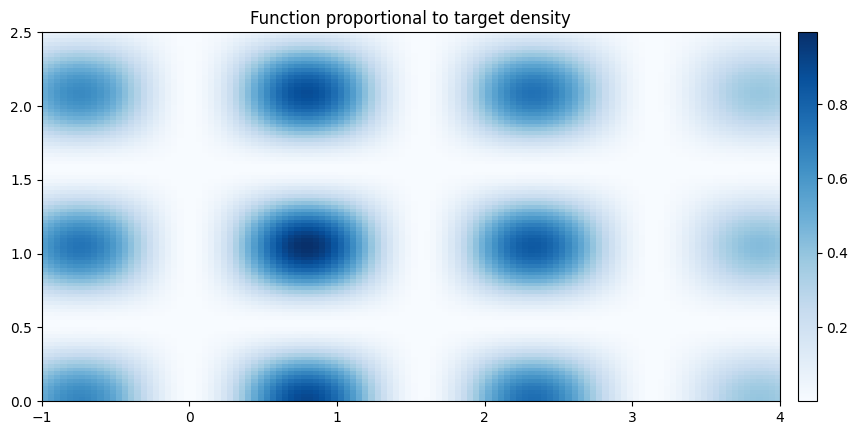

In [12]:
# Domain
x0min, x0max = -1.0, 4.0
x1min, x1max = 0.0, 2.5

xmin = np.array([x0min, x1min])
xmax = np.array([x0max, x1max])

# Plot of f
# Empty image
nx0, nx1 = 120, 100
sx0, sx1 = (x0max - x0min)/nx0, (x1max - x1min)/nx1
im_f = gn.img.Img(nx=nx0, ny=nx1, sx=sx0, sy=sx1, ox=x0min, oy=x1min, nv=0) 

# Add variable: evaluation of f
im_f.append_var(f(np.array((im_f.xx().reshape(-1), im_f.yy().reshape(-1))).T))

# Plot
plt.figure(figsize=(10, 10))
gn.imgplot.drawImage2D(im_f, cmap="Blues")
plt.title('Function proportional to target density')
plt.show()              

In [13]:
# Normalize image of f (density, sum to one)
im_fd = gn.img.copyImg(im_f)
im_fd.val = im_f.val/(im_f.val.sum() * im_f.sx*im_f.sy)

In [14]:
# Draw sample
n = 500000
np.random.seed(1239)
t1 = time.time()
x, t = gn.randProcess.acceptRejectSampler(n, xmin, xmax, f, return_accept_ratio=True, show_progress=False)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Acceptance ratio = {t:.4g}')

Elapsed time: 0.38 sec
Acceptance ratio = 0.2059


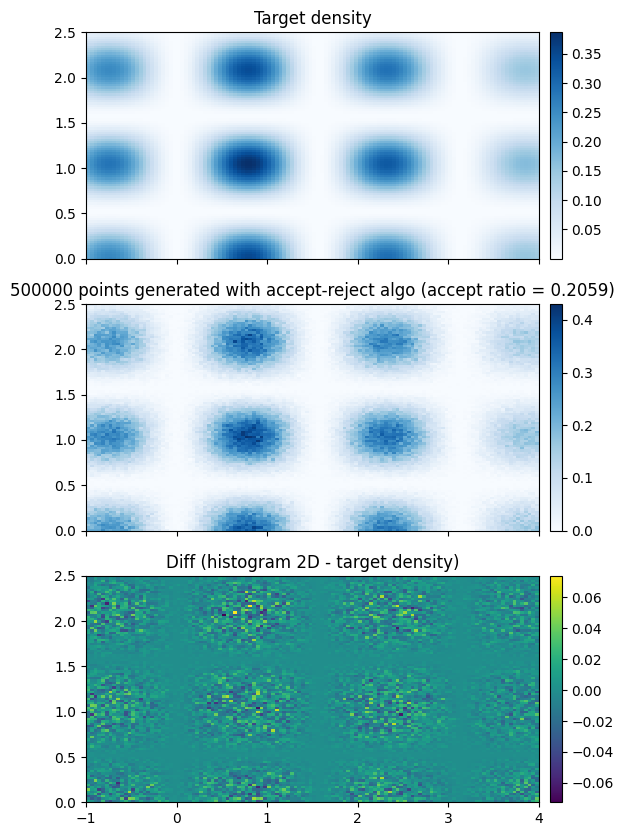

In [15]:
# Compute histogram (on same grid as image of f above)
H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1], bins=[im_f.ox+np.arange(im_f.nx+1)*im_f.sx, im_f.oy+np.arange(im_f.ny+1)*im_f.sy],
                                  density=True)
# Image of histogram 2D
im_H = gn.img.Img(nx=nx0, ny=nx1, sx=sx0, sy=sx1, ox=x0min, oy=x1min, nv=1, val=H.T) 

# Plot
plt.subplots(3,1, sharex=True, sharey=True, figsize=(8, 10))

plt.subplot(3,1,1)
gn.imgplot.drawImage2D(im_fd, cmap='Blues')
plt.title('Target density')

plt.subplot(3,1,2)
gn.imgplot.drawImage2D(im_H, cmap='Blues')
plt.title(f'{n} points generated with accept-reject algo (accept ratio = {t:.4g})')

im_diff = gn.img.copyImg(im_H)
im_H.val = im_H.val - im_fd.val

plt.subplot(3,1,3)
gn.imgplot.drawImage2D(im_H, cmap='viridis')
plt.title(f'Diff (histogram 2D - target density)')

plt.show()              

#### Specifying instrumental distribution
Set `g` and `g_rvs`; `c` will be computed automatically.

In [16]:
# Set instrumental distribution (g, g_rvs)
mean = np.array([1.5, 1.25]) #np.array([0.8, 1.2])
cov = np.array([2.2, 1.8])
g = lambda x: np.exp(-0.5*(((np.atleast_2d(x)-mean)**2/cov).sum(axis=1)))
# g = scipy.stats.multivariate_normal(mean=mean, cov=cov).pdf # Also possible
g_rvs = scipy.stats.multivariate_normal(mean=mean, cov=cov).rvs

In [17]:
# # Set instrumental distribution (g, g_rvs): uniform
# g = lambda x: 1
# def g_rvs(size=1):
#     return xmin + scipy.stats.uniform.rvs(size=(size,2))*(xmax-xmin)

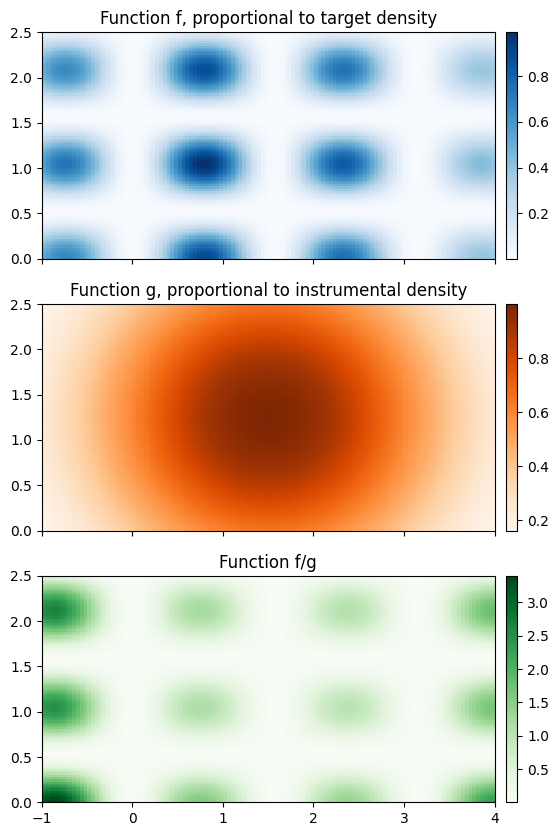

In [18]:
# Image of g
im_g = gn.img.Img(nx=nx0, ny=nx1, sx=sx0, sy=sx1, ox=x0min, oy=x1min, nv=1, 
                  val=g(np.array((im_f.xx().reshape(-1), im_f.yy().reshape(-1))).T))

# Image of f/g
im_f_over_g = gn.img.Img(nx=nx0, ny=nx1, sx=sx0, sy=sx1, ox=x0min, oy=x1min, nv=1, 
                         val=im_f.val/im_g.val)

# Plot
plt.subplots(3,1, sharex=True, sharey=True, figsize=(8, 10))

plt.subplot(3,1,1)
gn.imgplot.drawImage2D(im_f, cmap='Blues')
plt.title('Function f, proportional to target density')

plt.subplot(3,1,2)
gn.imgplot.drawImage2D(im_g, cmap='Oranges')
plt.title('Function g, proportional to instrumental density')

plt.subplot(3,1,3)
gn.imgplot.drawImage2D(im_f_over_g, cmap='Greens')
plt.title('Function f/g')

plt.show()              

In [19]:
# Draw sample
n = 500000
np.random.seed(1239)
t1 = time.time()
x, t = gn.randProcess.acceptRejectSampler(n, xmin, xmax, f, g=g, g_rvs=g_rvs, return_accept_ratio=True, show_progress=False)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Acceptance ratio = {t:.4g}')

Elapsed time: 1.1 sec
Acceptance ratio = 0.05966


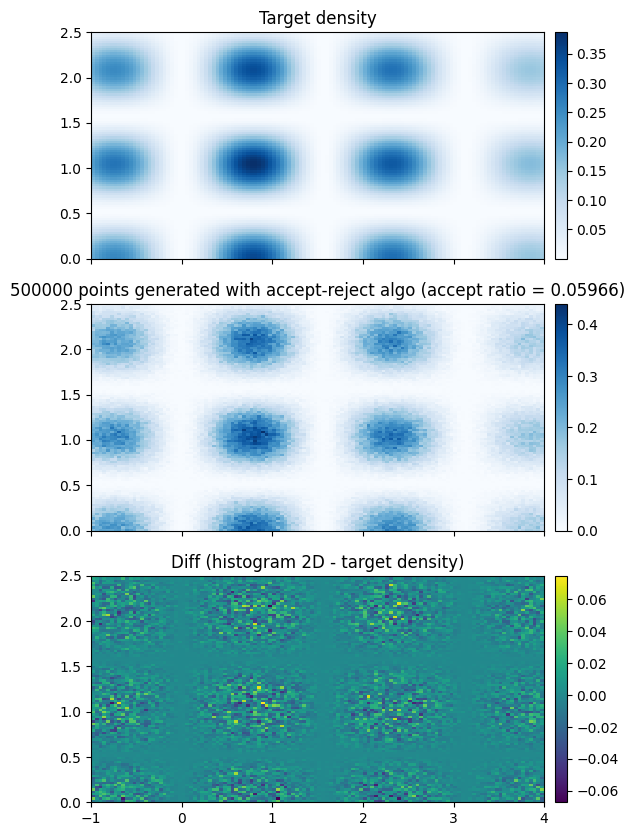

In [20]:
# Compute histogram (on same grid as image of f above)
H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1], bins=[im_f.ox+np.arange(im_f.nx+1)*im_f.sx, im_f.oy+np.arange(im_f.ny+1)*im_f.sy],
                                  density=True)
# Image of histogram 2D
im_H = gn.img.Img(nx=nx0, ny=nx1, sx=sx0, sy=sx1, ox=x0min, oy=x1min, nv=1, val=H.T) 

# Plot
plt.subplots(3,1, sharex=True, sharey=True, figsize=(8, 10))

plt.subplot(3,1,1)
gn.imgplot.drawImage2D(im_fd, cmap='Blues')
plt.title('Target density')

plt.subplot(3,1,2)
gn.imgplot.drawImage2D(im_H, cmap='Blues')
plt.title(f'{n} points generated with accept-reject algo (accept ratio = {t:.4g})')

im_diff = gn.img.copyImg(im_H)
im_H.val = im_H.val - im_fd.val

plt.subplot(3,1,3)
gn.imgplot.drawImage2D(im_H, cmap='viridis')
plt.title(f'Diff (histogram 2D - target density)')

plt.show()              

### Example - 2 variables on an infinite domain
With an infinite domain, the instrumental distribution (`g` and `g_rvs`), and `c` (greater than or equal to the maximum of `f/g`) must be specified.

In [21]:
# Function of 2 variables, proportional to target density
def f_2var(x0, x1):
    return np.exp(-((x0-1.0)**2+(x1-1.0)**2)/10.0)*np.sin(2*x0)**2*np.cos(3*x1)**2

# Same function, but taking an array as argument, where each row is one 2d point
f = lambda x: f_2var(x[...,0], x[...,1])

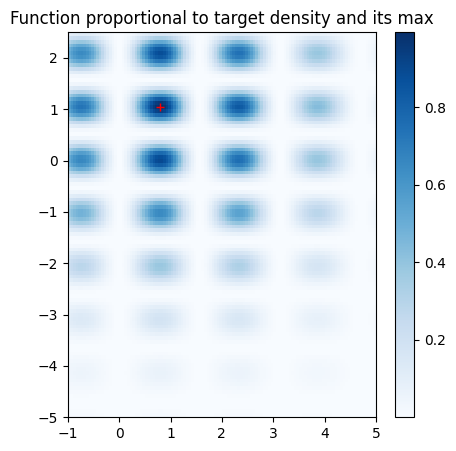

In [22]:
# Domain
x0min, x0max = -1.0, np.inf
x1min, x1max = -np.inf, 2.5

xmin = np.array([x0min, x1min])
xmax = np.array([x0max, x1max])

# Search the max of f (on a sub-domain)
xmin_tmp = np.array([x0min, -5.])
xmax_tmp = np.array([5., x1max])
h = lambda x: -f(x)
res = scipy.optimize.differential_evolution(h, bounds=list(zip(xmin_tmp, xmax_tmp)))
mu = res.x # maximizing f

# Plot of f
# Empty image
nx0, nx1 = 120, 100
sx0, sx1 = (xmax_tmp - xmin_tmp)/np.array([nx0, nx1])
im_f = gn.img.Img(nx=nx0, ny=nx1, sx=sx0, sy=sx1, ox=xmin_tmp[0], oy=xmin_tmp[1], nv=0) 

# Add variable: evaluation of f
im_f.append_var(f(np.array((im_f.xx().reshape(-1), im_f.yy().reshape(-1))).T))

# Plot
plt.figure(figsize=(5, 5))
gn.imgplot.drawImage2D(im_f, cmap="Blues")
plt.plot(mu[0], mu[1], color='red', marker='+')
plt.title('Function proportional to target density and its max')
plt.show()              

In [23]:
# Set instrumental distribution (g, g_rvs)
mean = mu
cov = np.array([5.6, 5.2])
g = lambda x: np.exp(-0.5*(((np.atleast_2d(x)-mean)**2/cov).sum(axis=1)))
# g = scipy.stats.multivariate_normal(mean=mean, cov=cov).pdf # Also possible
g_rvs = scipy.stats.multivariate_normal(mean=mean, cov=cov).rvs

# Search the max of f(x)/g(x) (on a sub-domain)
h = lambda x: -f(x)/g(x)
res = scipy.optimize.differential_evolution(h, bounds=list(zip(xmin_tmp, xmax_tmp)))
c = -res.fun # max f/g


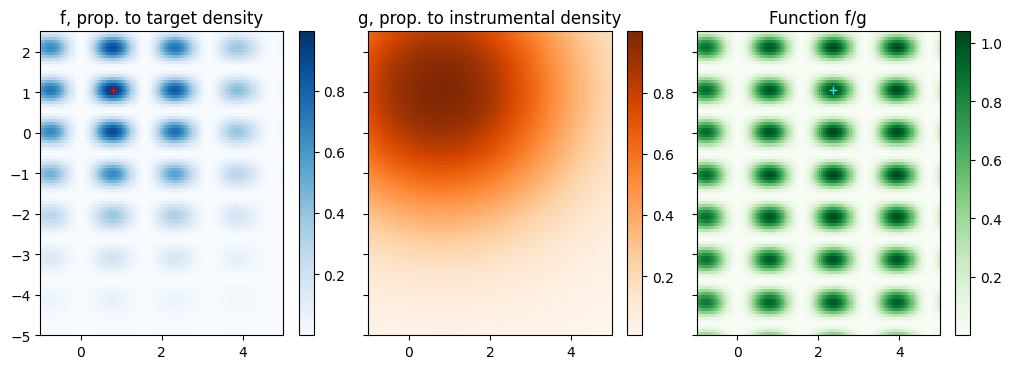

In [24]:
# Image of g (on a sub-domain)
im_g = gn.img.Img(nx=nx0, ny=nx1, sx=sx0, sy=sx1, ox=xmin_tmp[0], oy=xmin_tmp[1], nv=1, 
                  val=g(np.array((im_f.xx().reshape(-1), im_f.yy().reshape(-1))).T))

# Image of f/g (on a sub-domain)
im_f_over_g = gn.img.Img(nx=nx0, ny=nx1, sx=sx0, sy=sx1, ox=xmin_tmp[0], oy=xmin_tmp[1], nv=1, 
                         val=im_f.val/im_g.val)

# Plot
plt.subplots(1,3, sharex=True, sharey=True, figsize=(12, 8))

plt.subplot(1,3,1)
gn.imgplot.drawImage2D(im_f, cmap='Blues')
plt.plot(mu[0], mu[1], color='red', marker='+')
plt.title('f, prop. to target density')

plt.subplot(1,3,2)
gn.imgplot.drawImage2D(im_g, cmap='Oranges')
plt.title('g, prop. to instrumental density')

plt.subplot(1,3,3)
gn.imgplot.drawImage2D(im_f_over_g, cmap='Greens')
plt.plot(res.x[0], res.x[1], color='cyan', marker='+') # max of f/g
plt.title('Function f/g')

plt.show()              

In [25]:
# Normalize image of f (density, sum to one)
im_fd = gn.img.copyImg(im_f)
im_fd.val = im_f.val/(im_f.val.sum() * im_f.sx*im_f.sy)

In [26]:
# Draw sample
n = 500000
np.random.seed(1239)
t1 = time.time()
x, t = gn.randProcess.acceptRejectSampler(n, xmin, xmax, f, c=c, g=g, g_rvs=g_rvs, return_accept_ratio=True, show_progress=False)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.2g} sec')
print(f'Acceptance ratio = {t:.4g}')

Elapsed time: 0.55 sec
Acceptance ratio = 0.143


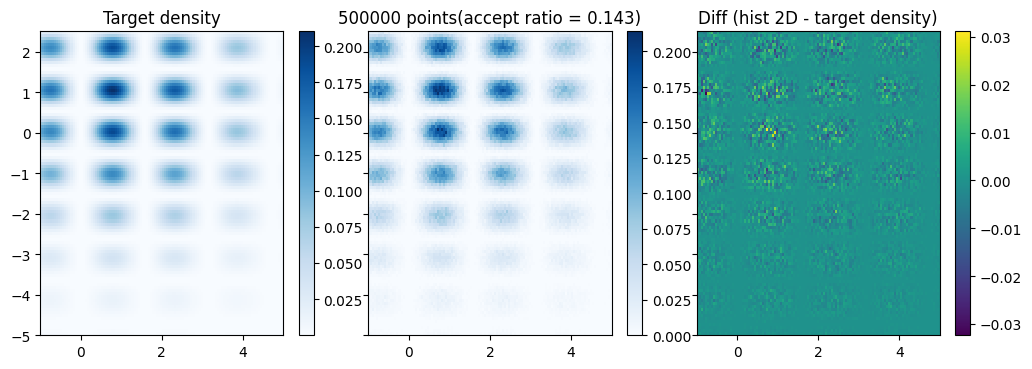

In [27]:
# Compute histogram (on same grid as image of f above)
H, xedges, yedges = np.histogram2d(x[:, 0], x[:, 1], bins=[im_f.ox+np.arange(im_f.nx+1)*im_f.sx, im_f.oy+np.arange(im_f.ny+1)*im_f.sy],
                                  density=True)
# Image of histogram 2D
im_H = gn.img.Img(nx=nx0, ny=nx1, sx=sx0, sy=sx1, ox=xmin_tmp[0], oy=xmin_tmp[1], nv=1, val=H.T) 

# Plot
plt.subplots(1,3, sharex=True, sharey=True, figsize=(12, 8))

plt.subplot(1,3,1)
gn.imgplot.drawImage2D(im_fd, cmap='Blues')
plt.title('Target density')

plt.subplot(1,3,2)
gn.imgplot.drawImage2D(im_H, cmap='Blues')
plt.title(f'{n} points(accept ratio = {t:.4g})')

im_diff = gn.img.copyImg(im_H)
im_H.val = im_H.val - im_fd.val

plt.subplot(1,3,3)
gn.imgplot.drawImage2D(im_H, cmap='viridis')
plt.title(f'Diff (hist 2D - target density)')

plt.show()              

Some points have been drawn out of the image grid above, which correspond to a sub-domain.

In [28]:
print('min coordinates of sample points:', x.min(axis=0))
print('max coordinates of sample points:', x.max(axis=0))

min coordinates of sample points: [-0.99999902 -9.62907583]
max coordinates of sample points: [11.38834381  2.49992052]
